Cite:
- GaborNet:https://github.com/qshobak/Transformation-invariant-Gabor-Convolutional-Networks
- Grad-Cam:https://github.com/MECLabTUDA/M3d-Cam
- TestDataSet:https://github.com/XavierJiezou/pytorch-cnn-mnist/tree/master/test

Environment:
- GPU P40-24G 数量： 1 显存： 24G GB
- torch==1.13.1 torchvision==0.14.1

In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from medcam import medcam

from net_factory import get_network_fn

In [2]:
# 数据准备
path = './test/'
imgs = []
labels = []
for name in sorted(os.listdir(path)):
    img = Image.open(path+name).convert('L')
    img = transforms.Resize(32)(img)
    img = transforms.ToTensor()(img)
    imgs.append(img)
    labels.append(int(name[0]))
imgs = torch.stack(imgs, 0)
# Init your model and dataloader
data_loader = DataLoader(imgs, batch_size=1, shuffle=False)

In [3]:
# 加载模型
model = get_network_fn('gaborCNN20')
checkpoint = torch.load('checkpoint.pth.tar',map_location='cpu')
print(checkpoint.keys())
model.load_state_dict(checkpoint['state_dict'])

dict_keys(['epoch', 'state_dict', 'best_prec1', 'optimizer'])


<All keys matched successfully>

In [4]:
# 测试模型
'''
model.eval()
for batch_idx, data in enumerate(data_loader):
    with torch.no_grad():
        output = model(data)
        print(output.argmax(1))
'''
# Inject model with M3d-CAM
model = medcam.inject(model, output_dir="output", save_maps=True)

# Continue to do what you're doing...
# In this case inference on some new data
model.eval()
outputs = []
for batch in data_loader:
    # Every time forward is called, attention maps will be generated and saved in the directory "attention_maps"
    output = model(batch)
    # more of your code...
    outputs.append(output.argmax(1).item())

In [5]:
import cv2
import numpy as np
# stolen from https://github.com/jacobgil/pytorch-grad-cam/blob/2183a9cbc1bd5fc1d8e134b4f3318c3b6db5671f/pytorch_grad_cam/utils/image.py
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")
        
    img = cv2.cvtColor(np.uint8(255*img),cv2.COLOR_GRAY2BGR)
    img = np.float32(img) / 255
    
    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return cam

[9, 1, 2, 3, 4, 5, 6, 7, 2, 5]
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


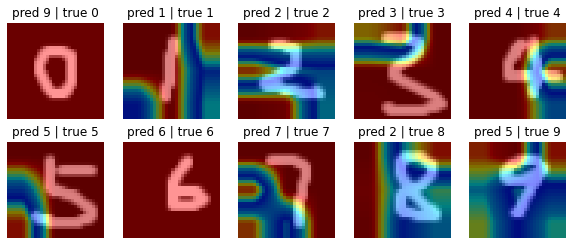

In [6]:
#%% 打印结果
pred = outputs
true = torch.LongTensor(labels)
print(pred)
print(true)
#%% 读取输出
path = './output/model.8/'
a_maps = []
for name in sorted(os.listdir(path)):
    a_map = Image.open(path+name).convert('L')
    a_map = transforms.Resize(32)(a_map)
    a_map = transforms.ToTensor()(a_map)
    a_maps.append(a_map)

#%% 结果显示
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(f'pred {pred[i]} | true {true[i]}')
    plt.axis('off')
    img=np.array(imgs[i].squeeze(0))
    img=img/np.max(img)
    mask=np.array(a_maps[i].squeeze(0))
    mask=mask/np.max(img)
    output = show_cam_on_image(img,mask)
    plt.imshow(output, cmap='gray')
plt.savefig('test.png')
plt.show()